In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, time, sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import cv2
# sys.path.append('/home/stringlab/Desktop/approxineuro/approxineuro')
from src import datasets, alexnet, metrics

%matplotlib inline

device = torch.device('cuda')

### make model

In [3]:
model = alexnet.AlexNet().to(device)

In [4]:
model_urls = {
'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}
state_dict = alexnet.load_state_dict_from_url(model_urls['alexnet'],
                                            progress=True)
model_dict = model.state_dict()
# match layer names in the pretrain model and current model
ks = list(model_dict.keys())
w_ks = list(state_dict.keys())
for i in range(len(ks)):
    if model_dict[ks[i]].shape == state_dict[w_ks[i]].shape:
        model_dict[ks[i]].copy_(state_dict[w_ks[i]])
    else:
        print(f'error matching weights: {ks[i]}, {w_ks[i]}')

### load stims

In [5]:
np.tile(np.arange(0, 8)[:,np.newaxis], (1, 2)).flatten()

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7])

In [11]:
# take indices from miguel's experiments
timgs, labels = datasets.load_txt32(r"Z:/data/STIM/", only_behav=False)

n_stims, Ly, Lx = timgs.shape
n_classes = labels.max() + 1
n_reps = n_stims // n_classes

16000 32 500


In [35]:
timgs, labels = datasets.load_behavtextures(r"Z:/data/STIM/", input_size=None, normalize=False)
n_stims, Ly, Lx = timgs.shape
n_classes = labels.max() + 1
n_reps = n_stims // n_classes

16 8 2


In [58]:
timgs, labels = datasets.load_8x4(r"Z:/data/STIM/", input_size=None, normalize=False)
n_stims, Ly, Lx = timgs.shape
n_classes = labels.max() + 1
n_reps = n_stims // n_classes

32 8 4


In [36]:
n_reps

2

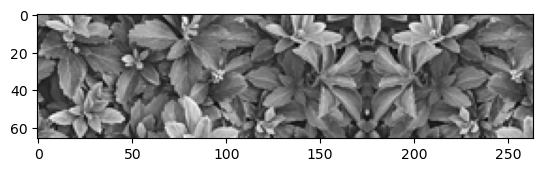

In [37]:
plt.imshow(timgs[0], cmap='gray')

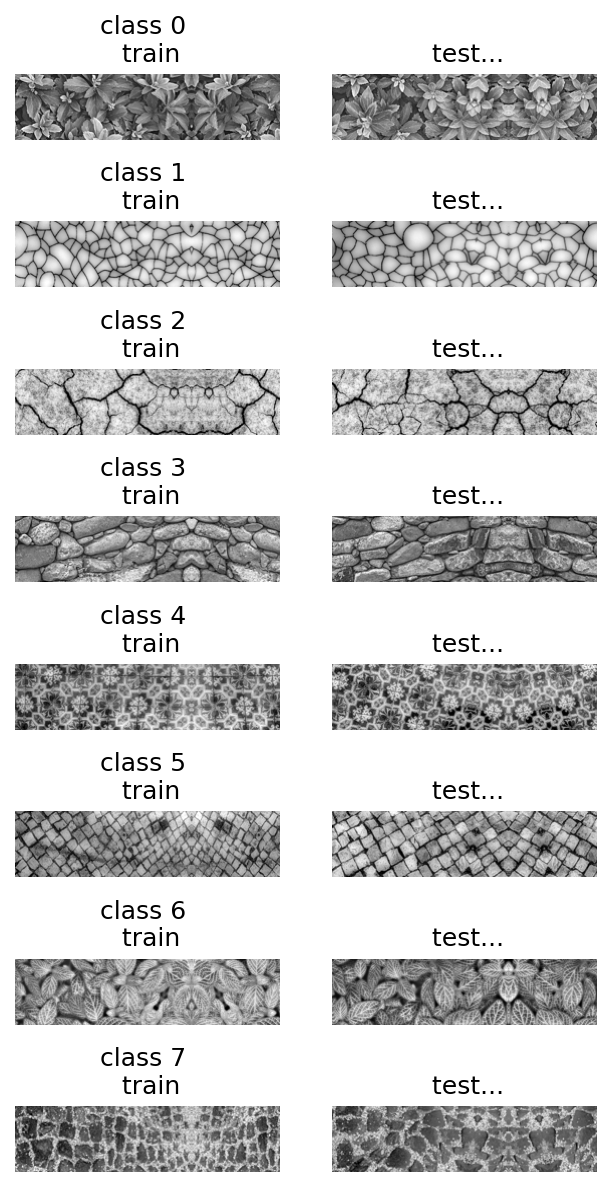

In [39]:
plt.figure(figsize=(5,10), dpi=150, facecolor='w')
for i in range(min(n_stims,80)):
    plt.subplot(8,2,i+1)
    plt.imshow(timgs[(i//2) * n_reps + i%2], cmap='gray')
    plt.axis('off')

In [33]:
np.arange(1, 6+1)

array([1, 2, 3, 4, 5, 6])

### compute responses + metrics

In [59]:
import imp
imp.reload(metrics)

ntrains = 2 ** np.arange(0, 9)
ntrains = np.append(ntrains, np.array([400]))
ntrains = ntrains[:1]
n_ntrain = len(ntrains)
n_layers = 6
layers = np.arange(0, n_layers+0)
accsL = np.nan * np.zeros((n_ntrain, n_layers, n_classes, n_classes))
accsK = np.nan * np.zeros((n_ntrain, n_layers, n_classes, n_classes)) 
dist = np.nan * np.zeros((n_ntrain, n_layers, n_classes, n_classes)) 
ltile = np.tile(layers[:,np.newaxis, np.newaxis], (1, n_classes, n_classes))

for l, layer in enumerate(layers):
    ### compute responses for model
    X = model.responses(timgs, layer=layer, batch_size=32)
    print(X.shape, X.max(), X.min())
    X = X.reshape(X.shape[0], -1)
    print(X.shape)

    for n, ntrain in enumerate(ntrains):
        print(f'>>> ntrain = {ntrain}')
        itrain = np.zeros(n_stims, 'bool')
        for k in range(ntrain):
            itrain[k::n_reps] = True
        itest = ~itrain
        
        ### compute performance on texture classification
        for i0 in range(n_classes):
            for i1 in range(i0+1, n_classes):
                accsL[n,l,i0,i1], accsK[n,l,i0,i1] = metrics.classifiers(X, labels, itrain, itest, 
                                                                 ipair=[i0, i1], verbose=False)

        print(f'LAYER {layer}; logreg: {np.nanmean(accsL[n,l]):.2f}, 1-NN: {np.nanmean(accsK[n,l]):.2f}')

(32, 64, 7, 32) 25.503416061401367 0.0
(32, 14336)
>>> ntrain = 1
LAYER 0; logreg: 0.60, 1-NN: 0.56
(32, 192, 3, 15) 33.83986282348633 0.0
(32, 8640)
>>> ntrain = 1
LAYER 1; logreg: 0.69, 1-NN: 0.74
(32, 384, 3, 15) 37.91429901123047 0.0
(32, 17280)
>>> ntrain = 1
LAYER 2; logreg: 0.91, 1-NN: 0.91
(32, 256, 3, 15) 27.94200325012207 0.0
(32, 11520)
>>> ntrain = 1
LAYER 3; logreg: 0.95, 1-NN: 0.95
(32, 256, 1, 7) 21.17238426208496 0.0
(32, 1792)
>>> ntrain = 1
LAYER 4; logreg: 0.96, 1-NN: 0.96
(32, 1000) 20.80040168762207 -14.927547454833984
(32, 1000)
>>> ntrain = 1
LAYER 5; logreg: 0.98, 1-NN: 0.98


In [60]:
for l, layer in enumerate(layers):
    ### compute responses for model
    X = model.responses(timgs, layer=layer, batch_size=32)
    X = X.reshape(X.shape[0], -1)
    exec(f'x{layer} = X')
np.savez('../results/features_8x4.npz', x0=x0, x1=x1, x2=x2, x3=x3, x4=x4, x5=x5)

In [192]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

# Sample dataset
X_train = np.array([[1, 1],[0,0]])
y_train = np.array([0, 1])

# Initialize the classifier with 1 neighbor
knn = KNeighborsClassifier(n_neighbors=1)

# Fit the classifier
knn.fit(X_train, y_train)

# Define two random test points
X_test = np.array([[.5, 1]])

# Find the distances to the nearest neighbors
distances, indices = knn.kneighbors(X_test)
acc = knn.score(X_test, [1])
# Print the distances
print("Distances to the nearest neighbors for the test points:")
print(distances)
print(indices)
print(acc)

Distances to the nearest neighbors for the test points:
[[0.5]]
[[0]]
0.0


In [189]:
indices

array([[1]], dtype=int64)

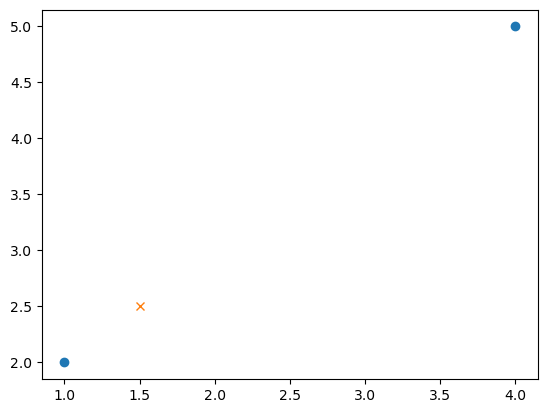

In [184]:
plt.plot(X_train[:,0], X_train[:,1], 'o')
plt.plot(X_test[:,0], X_test[:,1], 'x')

In [43]:
accsK[0,0,:,:]

array([[nan, 0.5, 0.5, 1. , 0.5, 0.5, 1. , 0.5],
       [nan, nan, 0.5, 1. , 0.5, 0.5, 0.5, 1. ],
       [nan, nan, nan, 0.5, 0.5, 0.5, 0.5, 0.5],
       [nan, nan, nan, nan, 0.5, 1. , 1. , 1. ],
       [nan, nan, nan, nan, nan, 1. , 0.5, 0.5],
       [nan, nan, nan, nan, nan, nan, 0.5, 1. ],
       [nan, nan, nan, nan, nan, nan, nan, 0.5],
       [nan, nan, nan, nan, nan, nan, nan, nan]])

In [162]:
accBhv = np.where(accsK <= 0.5, 0, accsK)

In [167]:
accBhv[0,0,:,:]

array([[nan,  0.,  0.,  1.,  0.,  0.,  1.,  0.],
       [nan, nan,  0.,  1.,  0.,  0.,  0.,  1.],
       [nan, nan, nan,  0.,  0.,  0.,  0.,  0.],
       [nan, nan, nan, nan,  0.,  1.,  1.,  1.],
       [nan, nan, nan, nan, nan,  1.,  0.,  0.],
       [nan, nan, nan, nan, nan, nan,  0.,  1.],
       [nan, nan, nan, nan, nan, nan, nan,  0.],
       [nan, nan, nan, nan, nan, nan, nan, nan]])

In [44]:
layers

array([0, 1, 2, 3, 4, 5])

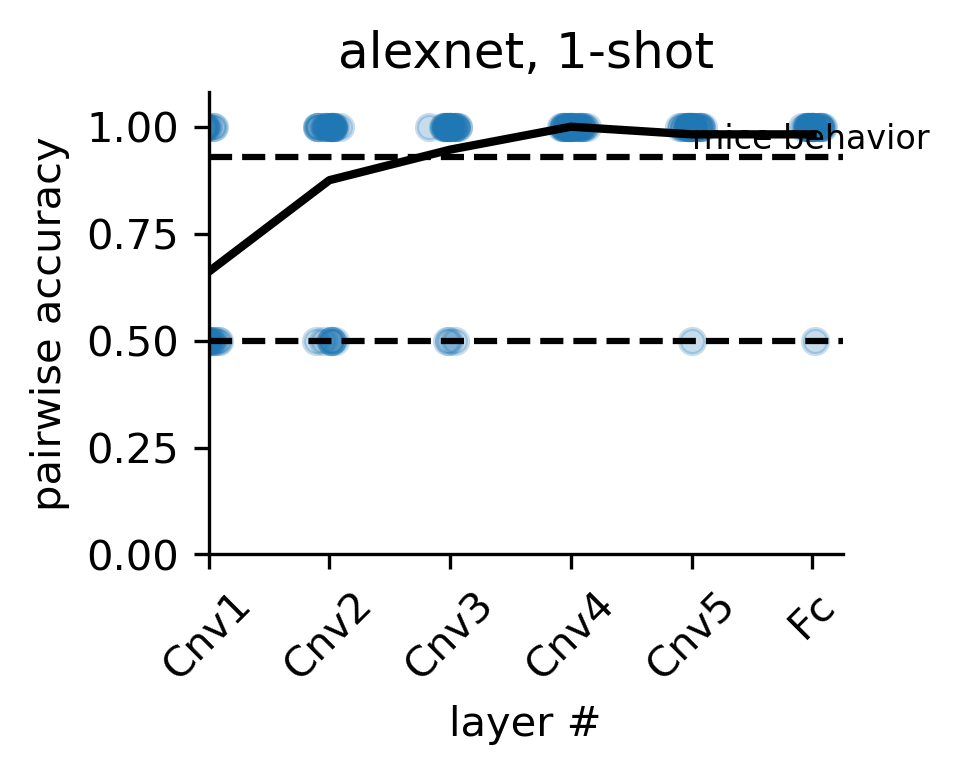

In [53]:
n = 0

from matplotlib.patches import Rectangle
fig=plt.figure(figsize=(6,2), dpi=300, facecolor='w')
ax = fig.add_subplot(1,2,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xl = ltile + 0.05*np.random.randn(*ltile.shape)
ax.scatter(xl, accsK[n], alpha=0.25)
#for i in np.arange(0, 6, 2):
#    ax.scatter(xl[:,i,i+1], accsK[n,:,i,i+1], alpha=1)

ax.plot(layers, np.nanmean(accsK[n], axis=(-2,-1)), color='k', lw=2)
ax.set_ylim([0,1.08])
ax.set_xlabel('layer #')
ax.set_ylabel('pairwise accuracy')
ax.set_title(f'alexnet, {ntrains[n]}-shot')
ax.hlines(0.93, 0, 6, 'k', '--')
# add text on top of line, saying mice behavior
ax.text(4, 0.95, 'mice behavior', color='k', fontsize=8)
ax.plot([0, 6], [0.5, 0.5], 'k--')
ax.set_xlim([0, 5.25])
ax.set_xticks(np.arange(0, 6), ["Cnv1", "Cnv2", "Cnv3", "Cnv4", "Cnv5", "Fc"], rotation=45)
#ax.set_title('texture classification')

In [54]:
figure_root = r"C:/Users/labadmin/Documents/GeneralizationPaper/Figure1"
# Save classification accuracy
np.save(os.path.join(figure_root, 'alexnet_texture_KNNclassification.npy'), accsK)

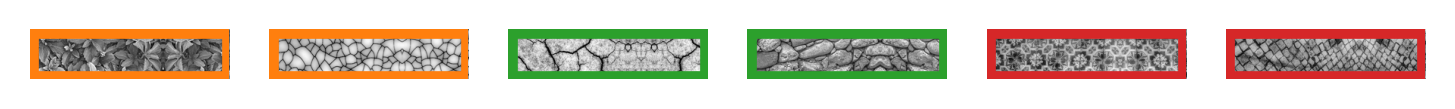

In [157]:
fig=plt.figure(figsize=(6,3), dpi=300, facecolor='w')
for i in np.arange(0, 6, 2):
    for j in range(2):
        ax = fig.add_subplot(1,6, i + j+1)
        ax.imshow(timgs[n_reps*(i+j)], cmap='gray')
        ax.add_patch(Rectangle([0,0], Lx, Ly, edgecolor=f'C{i//2+1}', facecolor='none', lw=4))
        ax.axis('off')